In [2]:
import numpy as np
import scanpy, scprep, phate, magic
import leidenalg
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import SPARC
import seaborn as sns
from collections import defaultdict, Counter
import SpatialDE
from scipy.stats import pearsonr, spearmanr, ranksums, ttest_ind

In [7]:
adata = scanpy.read_h5ad('data/V1_Human_Lymph_Node/processed.h5ad')

In [4]:
results = np.load('results/GSPA_QR.npz', allow_pickle=True)

In [5]:
phate_op = phate.PHATE(random_state=42)
data_phate = phate_op.fit_transform(results['signal_embedding'])

Calculating PHATE...
  Running PHATE on 1969 observations and 128 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.02 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.43 seconds.
    Calculating affinities...
    Calculated affinities in 0.11 seconds.
  Calculated graph and diffusion operator in 0.57 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 1.88 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.61 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.69 seconds.
Calculated PHATE in 7.78 seconds.


<Axes: title={'center': 'Localization Score'}, xlabel='Gene PHATE1', ylabel='Gene PHATE2'>

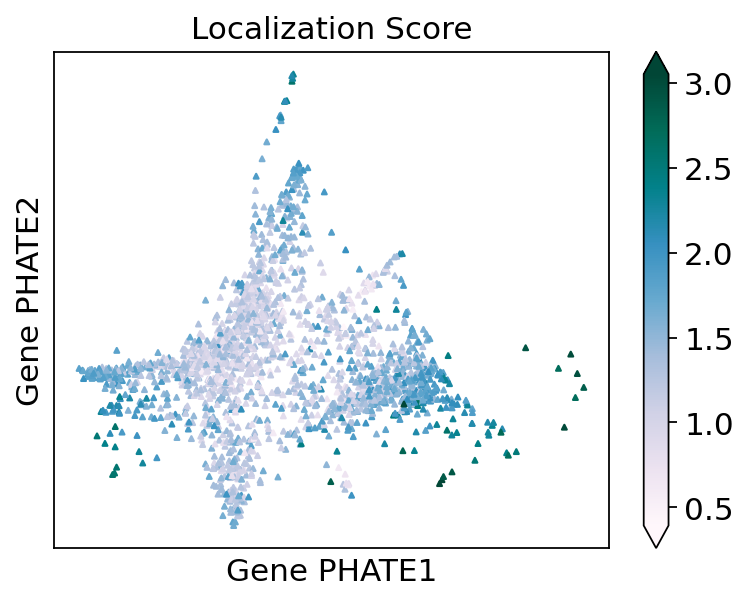

In [80]:
scprep.plot.scatter2d(data_phate, ticks=None, figsize=(5,4), c=results['localization_score'], dpi=200, 
                      filename='figures/localization.png',
                      cmap='PuBuGn',
                      vmin=np.percentile(results['localization_score'], 0.01),
                      vmax=np.percentile(results['localization_score'], 99.9),
                      title='Localization Score', label_prefix='Gene PHATE', legend_loc=(1.05,0), marker='^')

In [3]:
gene_summary = pd.read_csv('results/gene_summary.csv', index_col=0)

In [8]:
sparc_op = SPARC.spARC(n_jobs=-1, random_state=42)
data_sparc = sparc_op.fit_transform(expression_X = adata.to_df(),
                                    spatial_X = adata.obs[['array_row', 'array_col']], )

Calculating spARC...
  Calculating PCA...
  Calculated PCA in 15.54 seconds.
  Calculating expression graph...
  Calculated expression graph in 0.85 seconds.
  Calculating spatial graph...
  Calculated spatial graph in 1.51 seconds.
  Calculating random walks on expression graph...
  Calculated random walks on expression graph in 0.87 seconds.
  Calculating random walks on spatial graph...
  Calculating spARCed expression data...
  Calculated spARCed expression data in 3.24 seconds.
Calculated spARC in 22.02 seconds.


In [9]:
adata.layers['X_sparc'] = data_sparc.values

In [10]:
gene_summary['qval'] = adata.var.loc[gene_summary.index]['qval']

In [11]:
gene_summary['FSV'] = adata.var.loc[gene_summary.index]['FSV']

# where are top spatially-variable genes located?

In [189]:
spearmanr(gene_summary['localization_score'], -1*np.log10(gene_summary['qval']))

SignificanceResult(statistic=-0.021397996657035023, pvalue=0.3426166000733476)

In [190]:
spearmanr(gene_summary['localization_score'], gene_summary['FSV'])

SignificanceResult(statistic=0.13954669263886987, pvalue=5.013521211769669e-10)

In [105]:
sv_genes = adata.var[(adata.var['qval'] < 0.001) & (adata.var['FSV'] > 0.2)].index

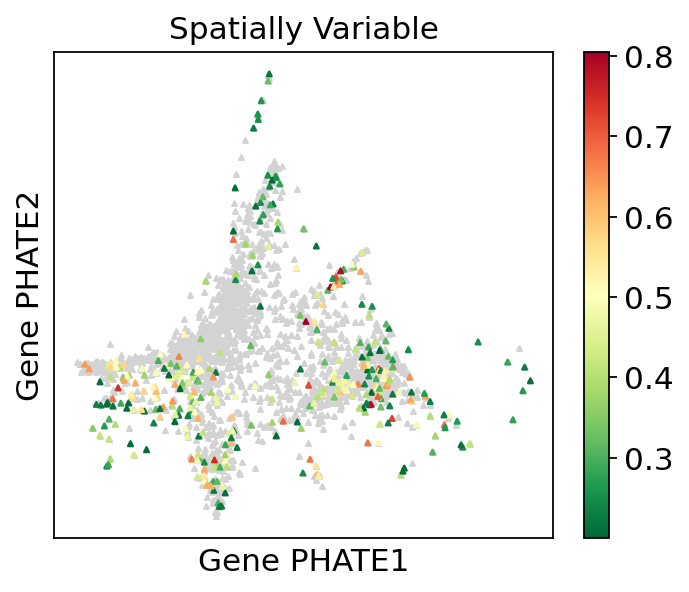

In [398]:
fig, ax = plt.subplots(figsize=(5,4))
scprep.plot.scatter2d(data_phate, ticks=None,  c='lightgray', dpi=200, ax=ax,
                      title='Spatially Variable', label_prefix='Gene PHATE', legend_loc=(1.05,0), marker='^')
scprep.plot.scatter2d(data_phate, ticks=None, ax=ax,
                      mask=pd.Series(results['genes']).isin(sv_genes),
                      dpi=200,
                      c=adata.var.loc[results['genes']]['FSV'], cmap='RdYlGn_r',
                      title='Spatially Variable', label_prefix='Gene PHATE', legend_loc=(1.05,0), marker='^')

fig.savefig('figures/spatially_variable.png', dpi=500)

In [239]:
mask = (gene_summary['qval'] < 0.01) & (gene_summary['FSV'] > 0.2)

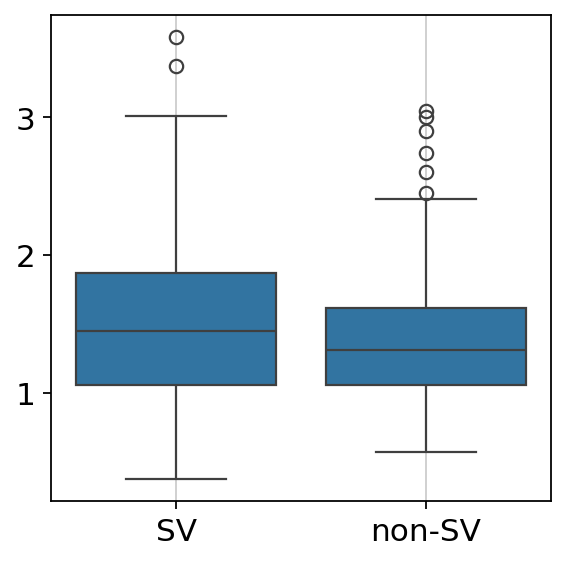

In [396]:
fig = plt.figure()
sns.boxplot(x=['SV'] * sum(mask) + ['non-SV'] * sum(~mask),
            y=gene_summary[mask]['localization_score'].tolist() + gene_summary[~mask]['localization_score'].tolist())
plt.grid(None)
fig.savefig('figures/loc_sv_boxplot.png', dpi=500)

In [256]:
ranksums(gene_summary[mask]['localization_score'].tolist(),
                     gene_summary[~mask]['localization_score'].tolist(), alternative='greater')

RanksumsResult(statistic=4.764454103832891, pvalue=9.468280598315155e-07)

In [386]:
gene_summary['qval'] = gene_summary['qval'].replace(0.0, 1e-40) ### q-value outliers removed for comparison

In [ ]:
histology_results, patterns = SpatialDE.aeh.spatial_patterns(X, resid_expr, sign_results, C=3, l=1.8, verbosity=1)

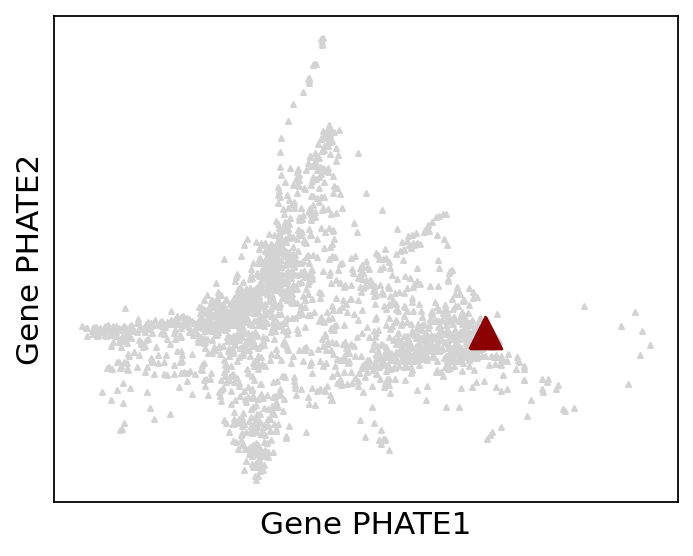

In [489]:
fig, ax = plt.subplots(figsize=(5,4))
scprep.plot.scatter2d(data_phate, ticks=None,  c='lightgray', dpi=200, ax=ax,
                      title='Spatially Variable', label_prefix='Gene PHATE', legend_loc=(1.05,0), marker='^')
scprep.plot.scatter2d(data_phate, ticks=None, ax=ax,
                      mask=pd.Series(results['genes']).isin(['CD34', 'MMRN2']),
                      dpi=200, s=200,
                      c='darkred',
                      title='', label_prefix='Gene PHATE', legend_loc=(1.05,0), marker='^')

fig.savefig('figures/cd34_mmrn2.png', dpi=500)

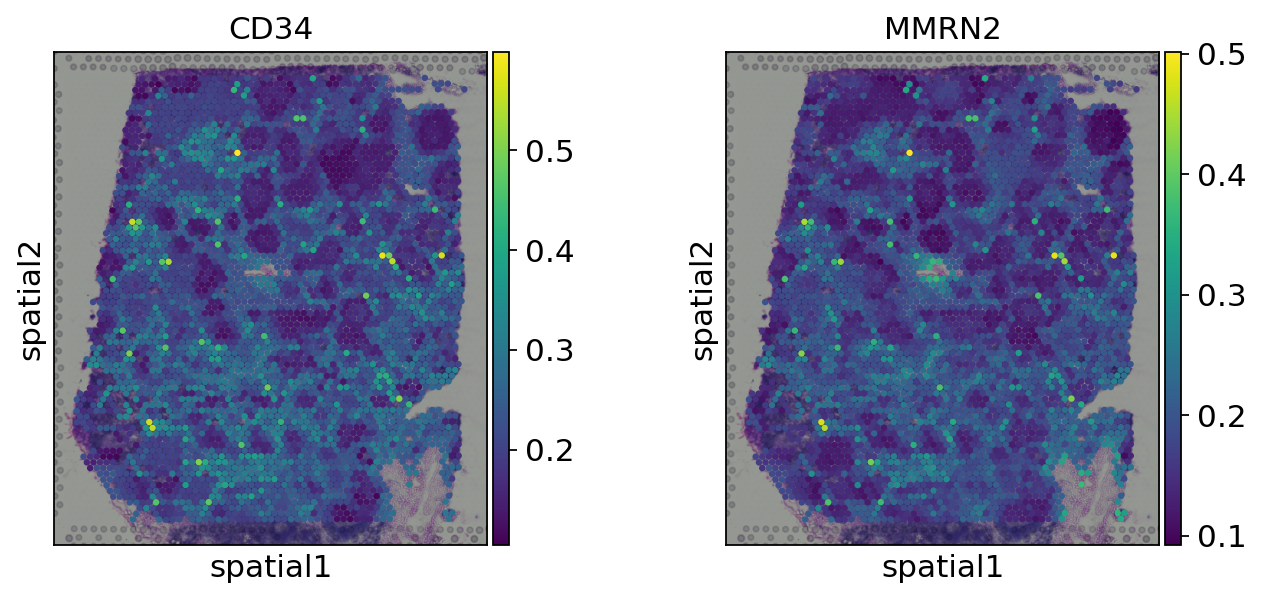

In [475]:
scanpy.pl.spatial(adata, color=['CD34', 'MMRN2'],
                      alpha_img=1, size=1.5, layer='X_sparc', save=f'spatialde_top_genes.png')

In [12]:
gene_summary.loc[['CD34', 'MMRN2']]

,gene_clusters,localization_score,ensembl,qval,FSV
CD34,0,2.021477,ENSG00000174059,0.213886,0.002330
MMRN2,0,2.012794,ENSG00000173269,0.293212,0.175196


In [467]:
gs = gene_summary[~(gene_summary['qval'] == 1.000000e-40)]

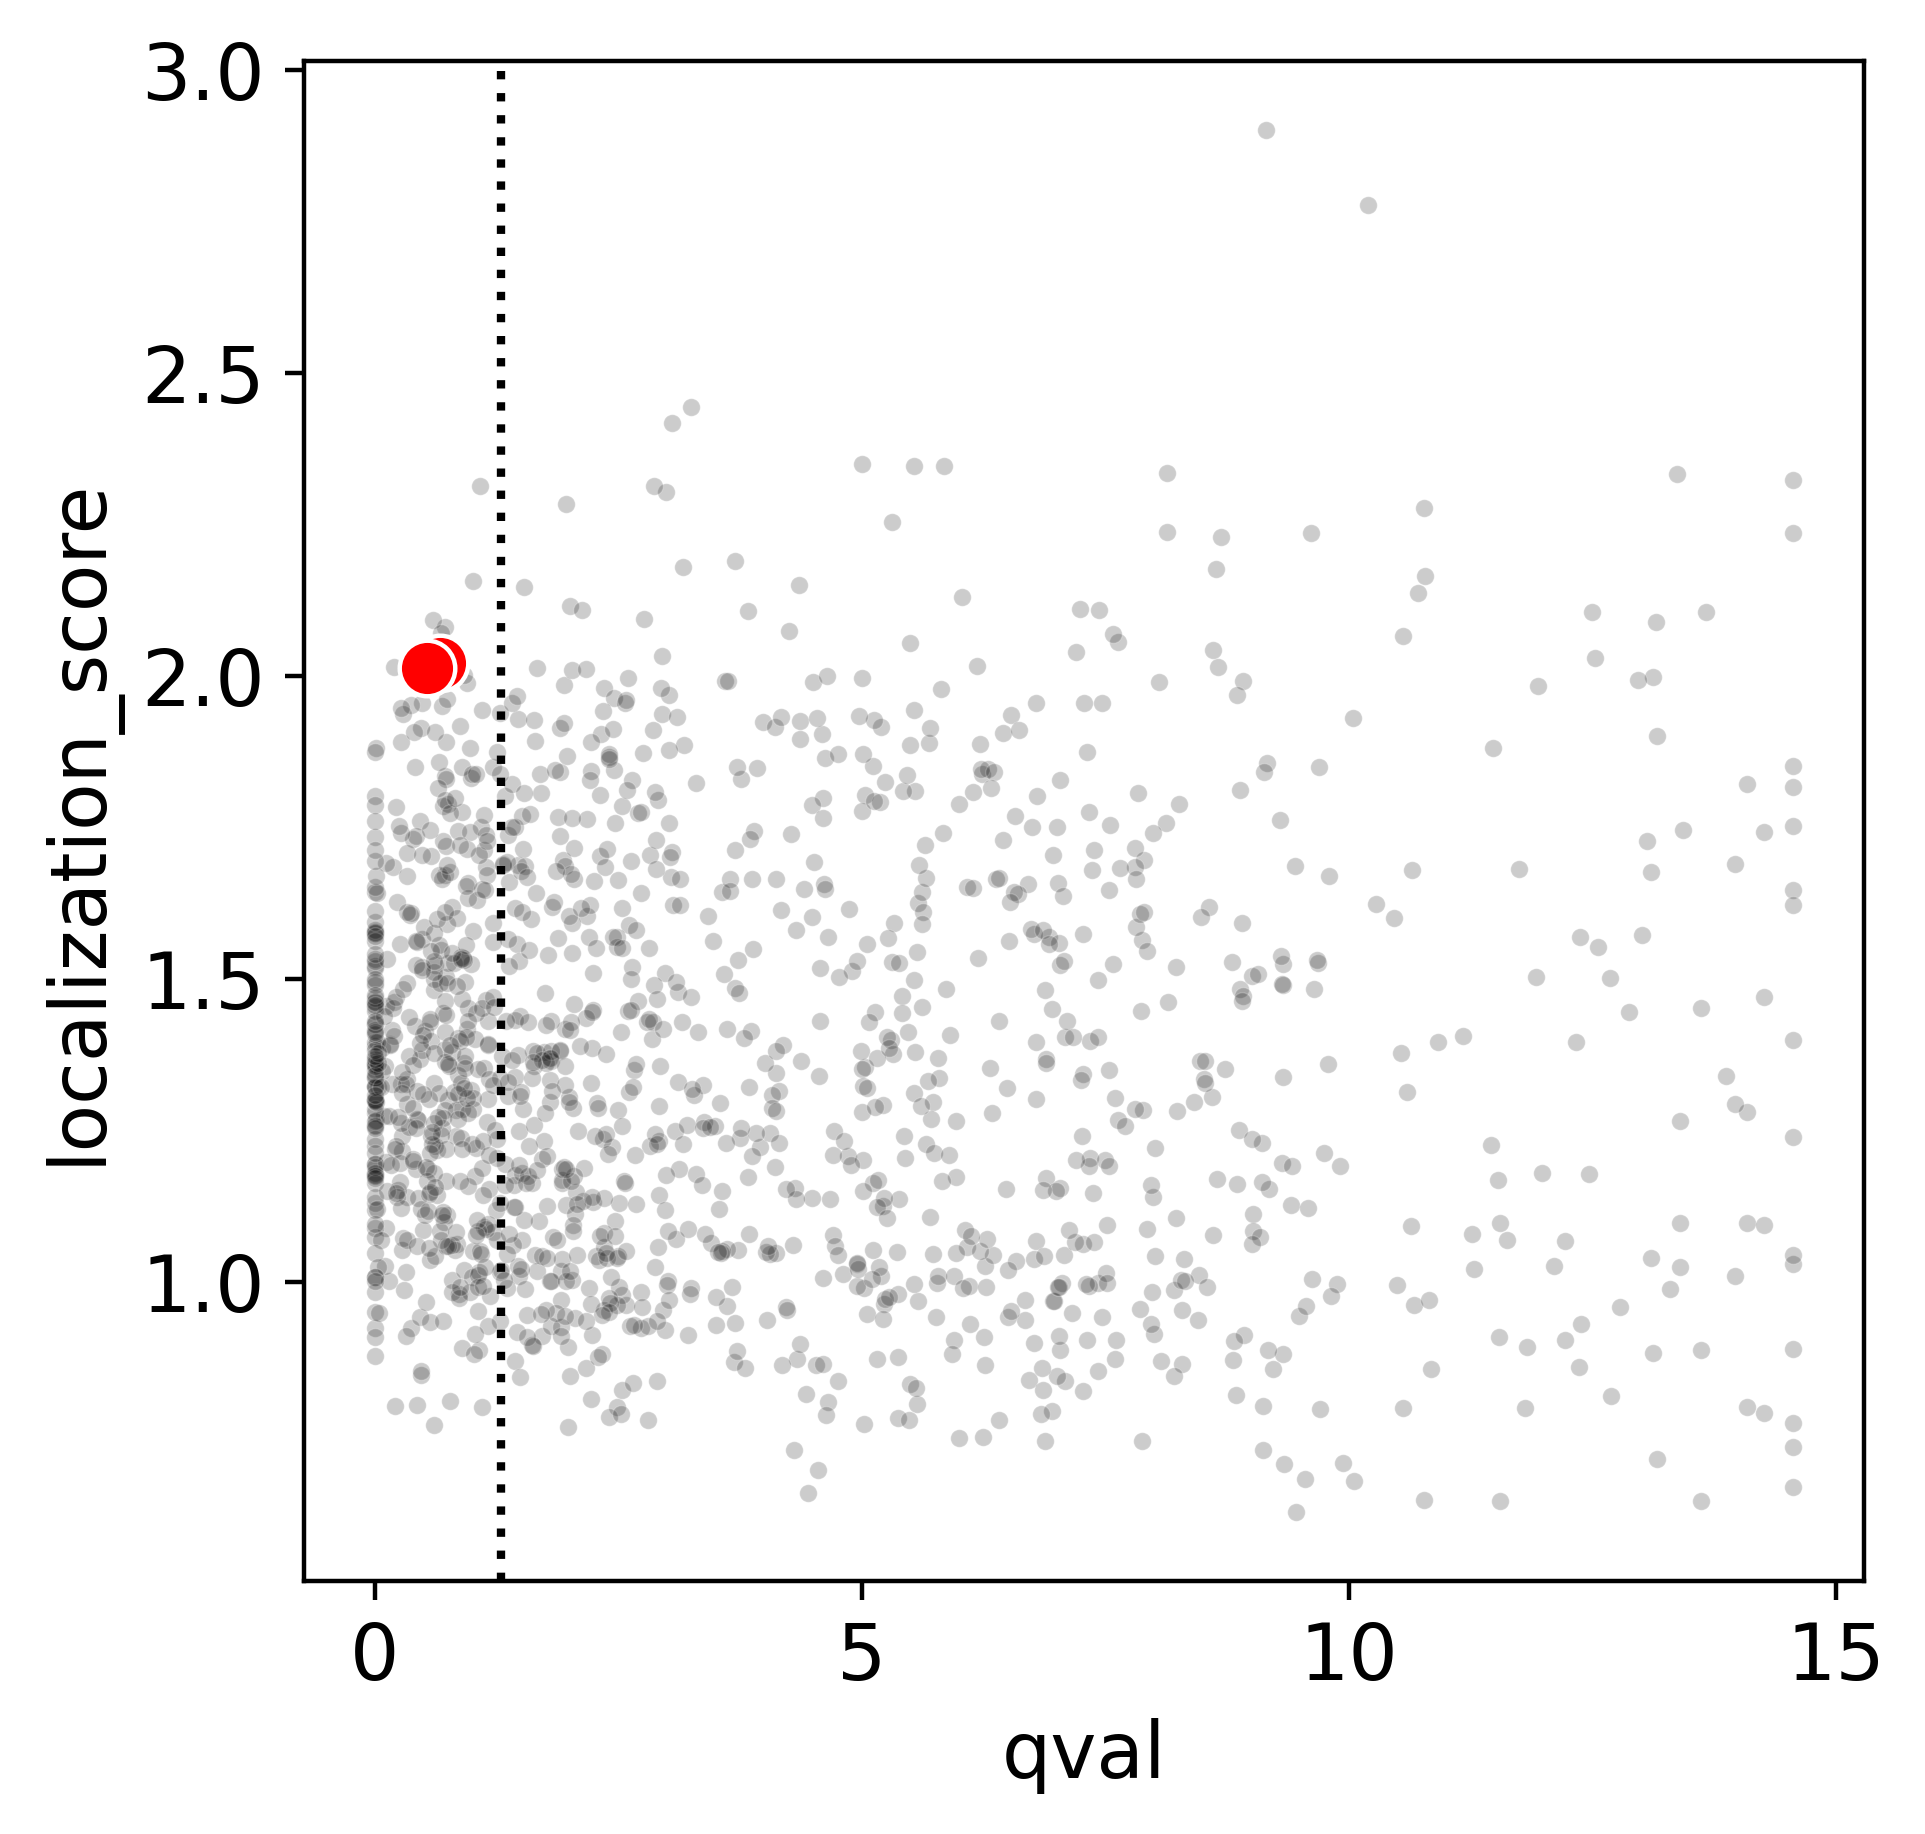

In [493]:
fig, ax = plt.subplots(figsize=(5,5), dpi=200)
sns.scatterplot(y=gs['localization_score'].values.tolist(),
                x=(np.log10(gs['qval']) * -1.0).tolist(),
                c='black', s=10, alpha=0.2)
sns.scatterplot(y=gs['localization_score'].loc[['CD34', 'MMRN2']], s=100,
                x=(np.log10(gs['qval']) * -1.0).loc[['CD34', 'MMRN2']], c='red')

ax.axvline(x=-1*np.log10(0.05), c='black', linestyle='dotted')
plt.grid(None)
fig.savefig('figures/cd34.png', dpi=500)